Plot composite time series next to each other

- spg dens
- composite of NAO
- max depth
- atmospheric heat flux at maximum
- northward heat transport
- convection
- cooling in north of STG
- warming in SPG
- first pc of bsf

In [1]:
import os
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pop_tools

Get latitudes

In [2]:
temp_file = os.path.expanduser('~/phase1_CONDA/')+'/results/composites/temp_anomaly.nc'
ds_temp = xr.open_dataset(temp_file).roll(nlon=+100)
ds_temp.TLAT.isel(nlon=0, nlat=310).values

array(43.30278477)

get masks

In [3]:
grid_name = 'POP_gx1v7'
region_defs = {
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}        
    ]}
mask_lab_sea = pop_tools.region_mask_3d(grid_name, 
                                  region_defs=region_defs, 
                                  mask_name='Labrador Sea')
mask_lab_sea = mask_lab_sea.sum('region')  

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Functions for metrics

In [21]:
# spg dens
spg_dens_mean = np.load(os.path.expanduser('~/phase1_CONDA/timeseries/spg_dens_mean.npy'))

# nao 
nao_mean = np.load(os.path.expanduser('~/phase1_CONDA/timeseries/nao_mean.npy'))

# depth at 43°N
da_dMOC = xr.open_dataarray('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/dMOCcomposite-test.nc')
dmoc_43N_mean = da_dMOC.isel(nlat=310).max('z_t').values

# atmospheric heat flux
ds_shf = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/SHFcomposite.nc').roll(nlon=+100).where(mask_lab_sea == 1)
shf_lab_sea_mean = ds_shf.SHF.mean(dim=('nlat', 'nlon')).values

# convection
ds_hmxl = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/HMXLcomposite.nc').roll(nlon=+100).where(mask_lab_sea == 1)
hmxl_lab_sea_mean = ds_hmxl.HMXL.mean(dim=('nlat', 'nlon')).values

# surface temperature
ds_temp = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/TEMPcomposite.nc').isel(z_t=0).roll(nlon=+100).where(mask_lab_sea == 1)
temp_surface_lab_mean = ds_temp.TEMP.mean(dim=('nlat', 'nlon')).values

Plot metrics

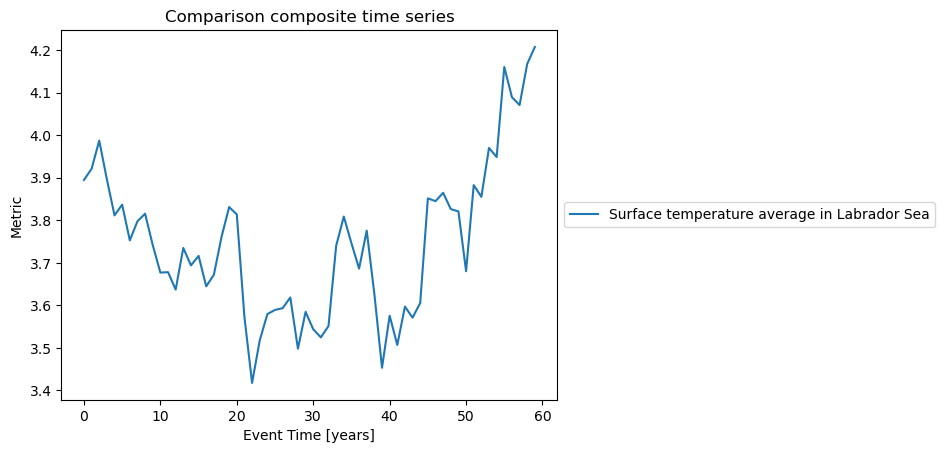

In [22]:
fig = plt.figure()

#plt.plot(spg_dens_mean, label=r'Density overturning at 55$^{\circ}$N')

#plt.plot(nao_mean, label=r'Accumulated NAO index')

#plt.plot(dmoc_43N_mean, label=r'Depth overturning at 43$^{\circ}$N')

#plt.plot(shf_lab_sea_mean, label=r'Surface Heat Flux average in Labrador Sea')

#plt.plot(hmxl_lab_sea_mean, label=r'Mixed layer depth average in Labrador Sea')

plt.plot(temp_surface_lab_mean, label=r'Surface temperature average in Labrador Sea')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r'Comparison composite time series')
plt.xlabel('Event Time [years]')
plt.ylabel('Metric')
plt.show()

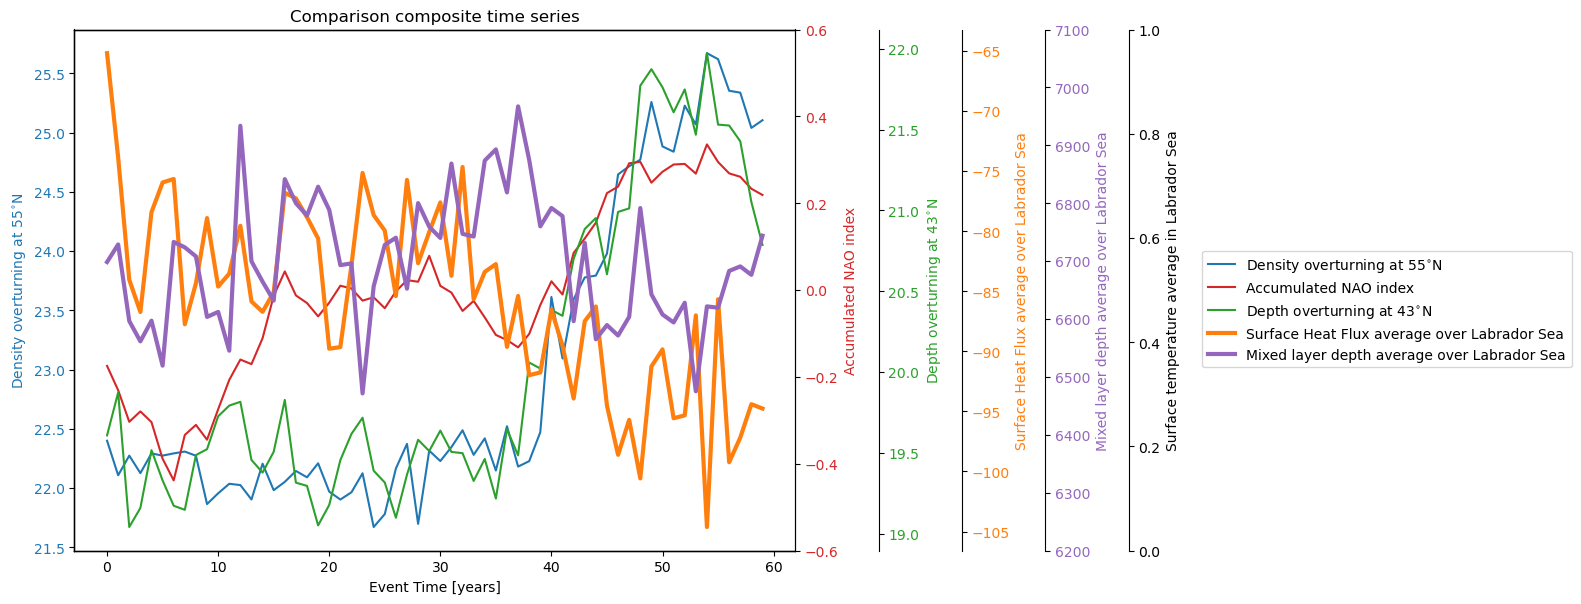

In [37]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Event Time [years]')
ax1.set_ylabel('Density overturning at 55$^{\circ}$N', color=color)
ax1.plot(spg_dens_mean, color=color, label='Density overturning at 55$^{\circ}$N')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Accumulated NAO index', color=color)  
ax2.plot(nao_mean, color=color, label='Accumulated NAO index')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-0.6, 0.6)  # Limit the y-axis from -2 to 2 for nao_mean

ax3 = ax1.twinx()  
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))  
ax3.set_ylabel('Depth overturning at 43$^{\circ}$N', color=color)  
ax3.plot(dmoc_43N_mean, color=color, label='Depth overturning at 43$^{\circ}$N')
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax1.twinx()  
color = 'tab:orange'
ax4.spines['right'].set_position(('outward', 120))  
ax4.set_ylabel('Surface Heat Flux average over Labrador Sea', color=color)  
ax4.plot(shf_lab_sea_mean, color=color, label='Surface Heat Flux average over Labrador Sea', linewidth=3)
ax4.tick_params(axis='y', labelcolor=color)

ax5 = ax1.twinx()  
color = 'tab:purple'
ax5.spines['right'].set_position(('outward', 180))  
ax5.set_ylabel('Mixed layer depth average over Labrador Sea', color=color)  
ax5.plot(hmxl_lab_sea_mean, color=color, label='Mixed layer depth average over Labrador Sea', linewidth=3)
ax5.tick_params(axis='y', labelcolor=color)
ax5.set_ylim(6200, 7100)

ax6 = ax1.twinx()  
color = 'black'
ax6.spines['right'].set_position(('outward', 240))  
ax6.set_ylabel('Surface temperature average in Labrador Sea', color=color)  
#ax6.plot(temp_surface_lab_mean, color=color, label='Surface temperature average in Labrador Sea', linewidth=2)
ax6.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Comparison composite time series')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.show()

plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'compare_metrics_3.png', bbox_inches='tight')